# Viseklasna klasifikacija koriscenjem SVM modela (OneVsRest)

Napravicemo jedan *OneVsRest SVM* model (klasifikator), zatim ispitati odredjena svojstva kao sto su *f1 ocena*, *matrica konfuzije*, *najrelevantnije reci* (koristeci *Tf-Idf*) i sl.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn import datasets
from sklearn import metrics
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn import svm
from sklearn import multiclass
from sklearn import model_selection
from sklearn import pipeline

In [3]:
import nltk

In [4]:
import pickle

In [5]:
import os

### Ucitavanje i priprema podataka

In [6]:
train_data = datasets.fetch_20newsgroups(random_state=61, remove=('headers'))
test_data = datasets.fetch_20newsgroups(random_state=61, subset='test', remove=('headers'))
X_train = train_data.data
y_train = train_data.target
X_test = test_data.data
y_test = test_data.target
feature_names = train_data.target_names
num_of_features = len(feature_names)
N_train = len(X_train)
N_test = len(X_test)

In [7]:
# ucitajmo vectorizer koji smo sacuvali da bi lakse filtrirali

In [8]:
with open(os.path.join("models", "vectorizer.pickle"), "rb") as load_file:
    vectorizer = pickle.load(load_file)

In [9]:
%%time
X_train_tfidf = vectorizer.transform(X_train)

CPU times: total: 16.5 s
Wall time: 16.5 s


In [10]:
%%time
X_test_tfidf = vectorizer.transform(X_test)

CPU times: total: 10.3 s
Wall time: 10.3 s


U osnovi viseklasnog klasifikatora ce nam biti linearni SVM klasifikator, sa *hinge* funkcijom greske.

In [12]:
svmodel = svm.LinearSVC(loss='hinge', multi_class='ovr')

In [13]:
#Hiperparametar C - sto je manji regularizacija je veca (default je l2 regularizacija)

Cs = [10**i for i in range(-4, 5)]

Pomocu unakrsne validacije odredicemo hiperparametar C, zatim model testirati na test skupu.

In [14]:
grid = model_selection.GridSearchCV(svmodel, param_grid={"C" : Cs}, scoring='accuracy', cv=5, return_train_score=True, verbose=1)

In [15]:
%%time
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\vkova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vkova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vkova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vkova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vkova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

CPU times: total: 4min 39s
Wall time: 4min 39s


C:\Users\vkova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(loss='hinge'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [16]:
#Zanimljive statistike unakrsne validacije

grid_results = pd.DataFrame(grid.cv_results_)

#grid_results.shape
#grid_results.columns

In [17]:
print("Best score: ", grid.best_score_)

Best score:  0.8896939697661962


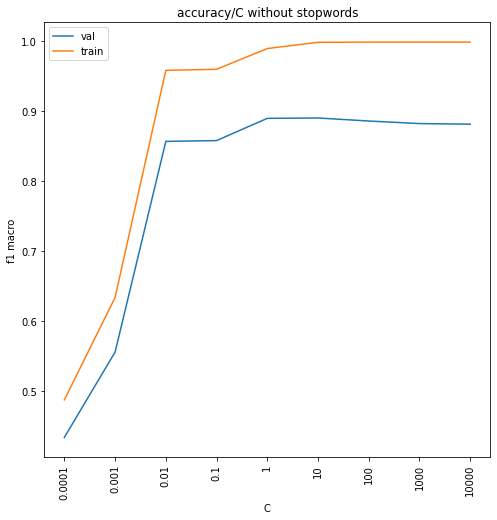

In [18]:
plt.figure(figsize=(8,8))

plt.title("accuracy/C without stopwords")
plt.plot(range(9), grid_results['mean_test_score'])
plt.plot(range(9), grid_results['mean_train_score'])
plt.legend(["val", "train"], loc='best')
plt.xlabel("C")
plt.ylabel("f1 macro")
plt.xticks(range(9), Cs, rotation='vertical')

plt.show()

In [19]:
best_C = grid.best_params_['C']

In [20]:
print("Best C: ", best_C)

Best C:  10


Kako skup za treniranje i validaciju nije prevelik, mozemo da konacni model istreniramo na celom skupu (a ne samo na trening skupu jednog sloja unakrsne validacije).

In [21]:
%%capture
model = svm.LinearSVC(loss='hinge', C=best_C)
model.fit(X_train_tfidf, y_train)

In [22]:
y_predicted = model.predict(X_test_tfidf)

In [23]:
#Zanimljivo, u [1] je acc=0.801, V=70631
#V - velicina vokabulara

print("Vocab size: ", len(vectorizer.vocabulary_))
print("Test accuracy: ", metrics.accuracy_score(y_test, y_predicted))

Vocab size:  45740
Test accuracy:  0.7943441317047265


In [28]:
# zasto nam se razlikuju sirine vokabulara ? 
# za razliku od clanka po kojem radimo, mi filtriramo reci frekvencije manje od 1

In [29]:
# sacuvamo model

In [25]:
with open(os.path.join("models", "svm2.model.pickle"), "wb") as dump_file:
    pickle.dump(model, dump_file)

# Ocenjivanje relevantnosti reci u dokumentu

***Relevenantnost*** reci dokumenta predstavlja ocenu ***vaznosti*** reci dokumenta pri klasifikaciji datog dokumenta - u kojoj meri je neka rec uticala (pozitivno ili negativno) na donetu odluku klasifikatora. 

In [30]:
# relevantnost u slucaju SVM klasifikatora dobijamo u odnosu na klasifikovanu klasu
# - tezine vezane za tu klasu predstavljaju relevantnost reci (+ bias_klase/)

In [31]:
vocabulary = vectorizer.vocabulary_

In [32]:
def word_relevance_coefs(text, category):
    text_tfidf = vectorizer.transform([text]).toarray()[0]
    D = text_tfidf.nonzero()[0].shape[0]
    relev = []
    coefs = model.coef_[category]
    b = model.intercept_[category]
    
    text = vectorizer.tokenizer(text)
    
    for word in text:
        if word not in vocabulary:
            relev.append(0)
        else:
            word_index = vocabulary[word]
            relev.append(coefs[word_index] + b/D)
        
    return relev

In [33]:
# KOMENTAR: ispraviti da prikazuje po 10 RAZLICITIH RECI
def visualize_relevance(text, category, num_of_words=10):
    relevances = word_relevance_coefs(text, category)
    relevances = np.array(relevances)
    
    
    positive_index = np.argsort(relevances)[-num_of_words:]
    negative_index = np.argsort(relevances)[:num_of_words]
    
    text = np.array(vectorizer.tokenizer(text))
    
    most_positively_relevant = relevances[positive_index]
    most_negatively_relevant = relevances[negative_index]
    positively_rel_words = text[positive_index]
    negatively_rel_words = text[negative_index]
    
    plt.figure(figsize=(8,8))
    
    plt.xticks(rotation=90)
    
    X = np.hstack([negatively_rel_words, positively_rel_words])
    y = np.hstack([most_negatively_relevant, most_positively_relevant])
    
    plt.title(feature_names[category])
    
    plt.bar(X, y)
    
    

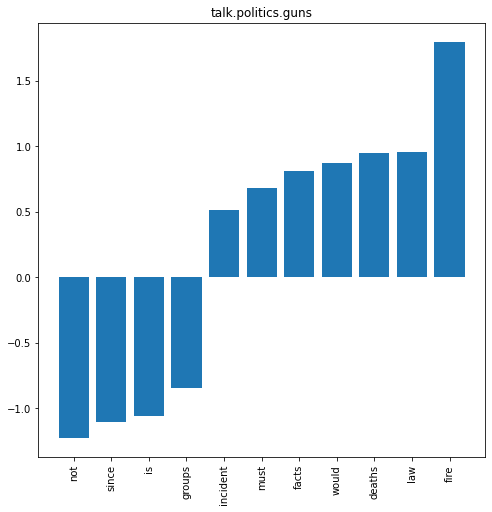

In [34]:
visualize_relevance(X_test[0], y_test[0], num_of_words=10)

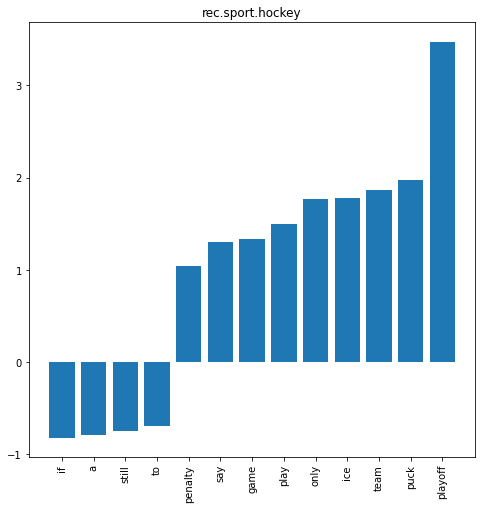

In [36]:
visualize_relevance(X_test[17], y_test[17], num_of_words=15)

In [43]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)

In [38]:
#print(confusion_matrix)

In [44]:
# deo matrice konfuzije 
confusion_matrix[:13,:13]

array([[238,   2,   0,   0,   1,   0,   2,   0,   0,   0,   2,   1,   1],
       [  2, 277,  21,  10,  10,  21,   9,   1,   2,   6,   0,   8,  11],
       [  0,  18, 263,  32,  19,  13,   6,   4,   0,   2,   4,   3,   8],
       [  0,  14,  26, 271,  26,   6,  16,   2,   2,   0,   0,   2,  20],
       [  0,   8,   7,  33, 291,   3,  12,   3,   1,   2,   3,   0,  16],
       [  0,  39,  24,  10,   6, 290,   4,   2,   1,   0,   2,   1,   5],
       [  0,   5,   2,  11,  15,   1, 325,   4,   4,   4,   6,   3,   7],
       [  0,   4,   4,   4,   2,   0,  10, 337,  10,   3,   1,   0,  12],
       [  1,   0,   0,   0,   2,   1,   4,  16, 365,   2,   0,   0,   2],
       [  1,   0,   0,   1,   1,   0,   4,   0,   2, 364,  13,   0,   1],
       [  1,   3,   0,   0,   2,   0,   1,   0,   0,   8, 376,   0,   0],
       [  0,   3,   2,   3,   5,   1,   5,   1,   4,   1,   0, 353,   5],
       [  0,   4,  12,  30,   7,   2,  15,   8,   5,   3,   0,  11, 274]],
      dtype=int64)

In [45]:
matrix_to_plot = np.fill_diagonal(confusion_matrix, 0)

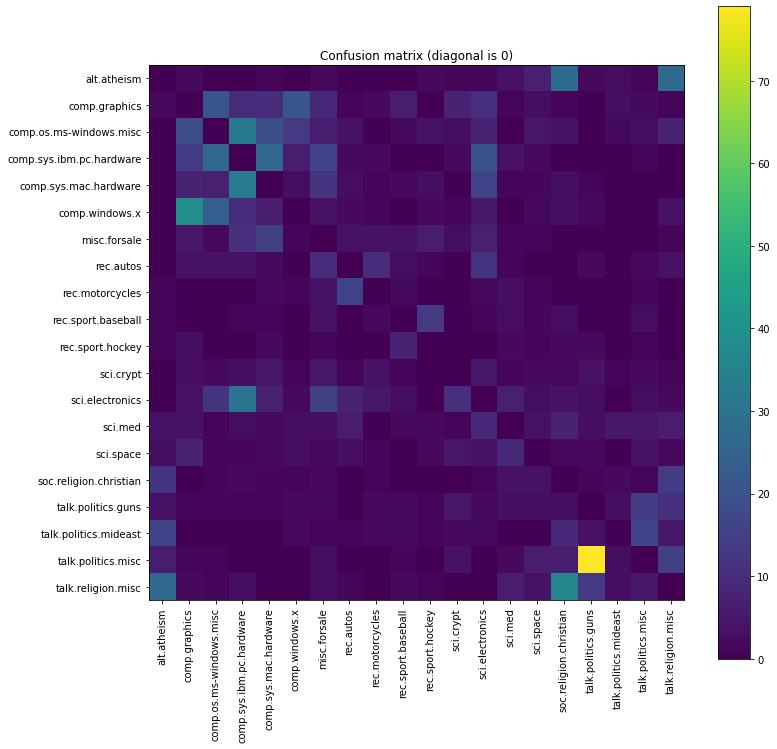

In [46]:
plt.figure(figsize=(12,12))

plt.xticks(ticks=range(len(feature_names)), labels=feature_names, rotation=90)
plt.yticks(ticks=range(len(feature_names)), labels=feature_names)

plt.title("Confusion matrix (diagonal is 0)")
plt.imshow(confusion_matrix)
plt.colorbar()

plt.show()

In [208]:
# mozemo primetiti koje se klase najvise mesaju:
# npr. talk.politics.guns - talk.politics.misc
# npr. sco.religion.christion - talk.religion.misc
# npr. comp.windows.x - com.graphics

In [47]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       319
           1       0.70      0.71      0.71       389
           2       0.72      0.67      0.69       394
           3       0.65      0.69      0.67       392
           4       0.74      0.76      0.75       385
           5       0.83      0.73      0.78       395
           6       0.76      0.83      0.79       390
           7       0.87      0.85      0.86       396
           8       0.91      0.92      0.91       398
           9       0.90      0.92      0.91       397
          10       0.91      0.94      0.92       399
          11       0.88      0.89      0.89       396
          12       0.72      0.70      0.71       393
          13       0.86      0.82      0.84       396
          14       0.87      0.86      0.87       394
          15       0.75      0.88      0.81       398
          16       0.72      0.83      0.77       364
          17       0.93    